# Random K-SAT Contraction

This notebook showcases examples of tensor network contraction for random K-SAT, using [`cotengra`](https://cotengra.readthedocs.io/en/)-based contractions.

In [1]:
import warnings
with warnings.catch_warnings(action="ignore"):
    # Disable warning about kahypar on windows
    import cotengra as ctg

import matplotlib.pyplot as plt

In [2]:
from tensorsat.contractions.cotengra import CotengraContraction
from tensorsat.diagrams import Diagram, DiagramBuilder
from tensorsat.lang.fin_rel import FinRel
from tensorsat.lib.bincirc import bits, or_, bit_1, not_, binop_labels
from tensorsat.lib.sat import CNFInstance
from tensorsat.viz.diagrams import draw_diagram

## Baby 3-SAT Example

We start by looking at a baby example of a 3-SAT formula in CNF, with 4 variables and 4 clauses.
Clauses follow the same format as [DIMACS](https://jix.github.io/varisat/manual/0.2.0/formats/dimacs.html): literals are encoded as non-zero integers, with the sign indicating whether the literal is positive or negated, and the magnitude indicating the variable.

In [3]:
cnf = CNFInstance.random(k=3, n=4, m=4, rng=0)
cnf.clauses

((2, 3, 4), (-4, -3, -1), (-3, -2, 4), (-4, -3, 1))

Below we show the correspondence between clauses and the formula, keeping in mind that variables are zero-indexed, and magnitudes of integers correspond to the 1 plus the corresponding variable indices: 

```
((2 , 3, 4) , (-4 ,-3 ,-1 ) , (-3 ,-2 ,4 ) , (-4 ,-3 ,1 ))
 (x1|x2|x3) & (~x3|~x2|~x0) & (~x2|~x1|x3) & (~x3|~x2|x0)
```

Below is a representation of the formula as a diagram:

- Variables are input ports (numbered) connected to hyperedges (solid gray nodes)
- Each negation is a 2-legged node labelled `~`.
- Each disjunction is a 3-legged node labelled `|`.
- The assertion that each clause must be true is a 1-legged node labelled `1` (i.e. true).

The diagram was created using the default scheme, where each clause is converted into a balanced binary tree of binary disjunction operations.

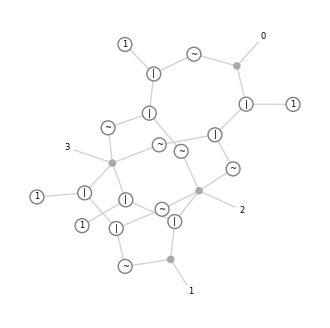

In [4]:
cnf_diagram = cnf.diagram()
draw_diagram(
    cnf_diagram,
    node_label={"box": binop_labels},
    figsize=(4,4)
)

Below is an explicit, circuit-like construction for the diagram:

In [5]:
@Diagram.from_recipe
def _cnf_diagram(builder: DiagramBuilder) -> None:
    # Inputs:
    x0, x1, x2, x3 = builder.add_inputs(bits(4))
    # Clause (x1|x2|x3):
    x4, = or_ @ builder[x1, x2]
    x5, = or_ @ builder[x4, x3]
    bit_1 @ builder[x5]
    # Clause (~x3|~x2|~x0):
    x6, = not_ @ builder[x3]
    x7, = not_ @ builder[x2]
    x8, = not_ @ builder[x0]
    x9, = or_ @ builder[x6, x7]
    x10, = or_ @ builder[x9, x8]
    bit_1 @ builder[x10]
    # Clause (~x2|~x1|x3):
    x11, = not_ @ builder[x2]
    x12, = not_ @ builder[x1]
    x13, = or_ @ builder[x11, x12]
    x14, = or_ @ builder[x13, x3]
    bit_1 @ builder[x14]
    # Clause (~x3|~x2|x0):
    x15, = not_ @ builder[x3]
    x16, = not_ @ builder[x2]
    x17, = or_ @ builder[x15, x16]
    x18, = or_ @ builder[x17, x0]
    bit_1 @ builder[x18]

assert _cnf_diagram == cnf_diagram


Below is the diagram, with all wires explicitly shown and annotated with the same variable names used by the circuit-like description above:

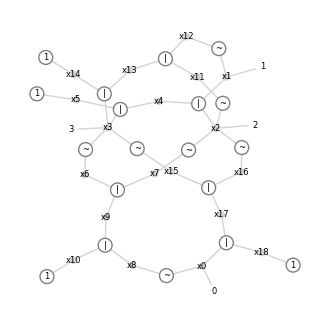

In [6]:
cnf_diagram = cnf.diagram()
draw_diagram(
    cnf_diagram,
    node_label={"box": binop_labels, "wire": lambda w: f"x{w}"},
    node_color={"wire": "lightgray"},
    simplify_wires=False,
    figsize=(4,4)
)

For larger circuits, the individual operation labels become hard to read, so we adopt a colour-coded approach to display the formulae:

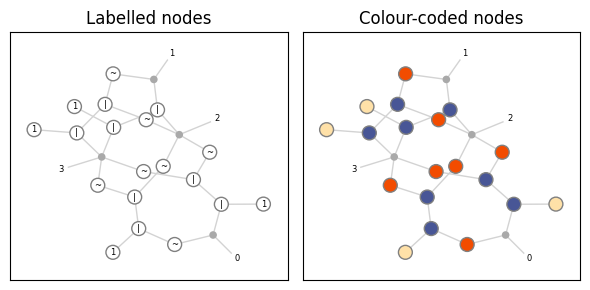

In [7]:
binop_colors = {
    or_: "#485696",   # blue
    not_: "#F24C00",  # orange
    bit_1: "#FFE1A8", # yellow
}
cnf_diagram = cnf.diagram()
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.title("Labelled nodes")
draw_diagram(
    cnf_diagram,
    node_label={"box": binop_labels},
    ax=plt.gca()
)
plt.subplot(1,2,2)
plt.title("Colour-coded nodes")
draw_diagram(
    cnf_diagram,
    node_color={"box": binop_colors},
    ax=plt.gca()
)
plt.tight_layout()
plt.show()

## Cotengra Contractions

We will now proceed to demonstrate three applications of tensor contraction to satisfiability:

- Computing (the indicator function for ) the set of all satisfying assignment.
- Checking whether the formula is satisfiable.
- Finding a single satisfying assignment.

We define a utility function `describe_contraction` to print relevant information from the [`cotengra` contraction trees](https://cotengra.readthedocs.io/en/latest/autoapi/cotengra/core/index.html#cotengra.core.ContractionTree).

In [8]:
def magnitude_str(n: int, suffix: str = "", prec: int = 1) -> str:
    if n < 2**10:
        return f"{n} {suffix}"
    for i, c in enumerate("KMGTPEZYRQ"):
        if n < 2**((i+2)*10):
            return f"{n/2**((i+1)*10):.{prec}f} {c}i{suffix}"
    return f"{n/2**100:.{prec}f}{c} Qi{suffix}"

def describe_contraction(t: ctg.ContractionTree) -> None:
    print(f"Num contractions: {t.N}")
    print(f"Total compute: {magnitude_str(t.total_flops(), "OPs")}")
    print(f"Total memory write: {magnitude_str(t.total_write(), "B")}")
    print(f"Max tensor size: {magnitude_str(t.max_size(), "B")}")
    print(f"Peak memory size: {magnitude_str(t.peak_size(), "B")}")
    if num_slices := len(t.sliced_inds):
        print(f"Num slices: {num_slices}")

The `CotengraContraction` class instantiates a contraction based on the [`cotengra.array_contract_tree`](https://cotengra.readthedocs.io/en/latest/autoapi/cotengra/index.html#cotengra.array_contract_tree) function.
The resulting [`cotengra` contraction tree](https://cotengra.readthedocs.io/en/latest/autoapi/cotengra/core/index.html#cotengra.core.ContractionTree) can be accessed via the `tree` property.

Num contractions: 19
Total compute: 232 OPs
Total memory write: 132 B
Max tensor size: 16 B
Peak memory size: 104 B


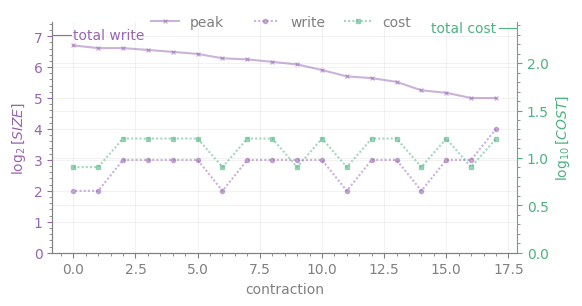

In [9]:
cnf_contraction = CotengraContraction(FinRel, cnf_diagram.wiring)
t = cnf_contraction.tree
describe_contraction(t)
t.plot_contractions(figsize=(6, 3));

## Small 4-SAT Example

We consider a 4-SAT formula with 10 variables and 95 clauses.

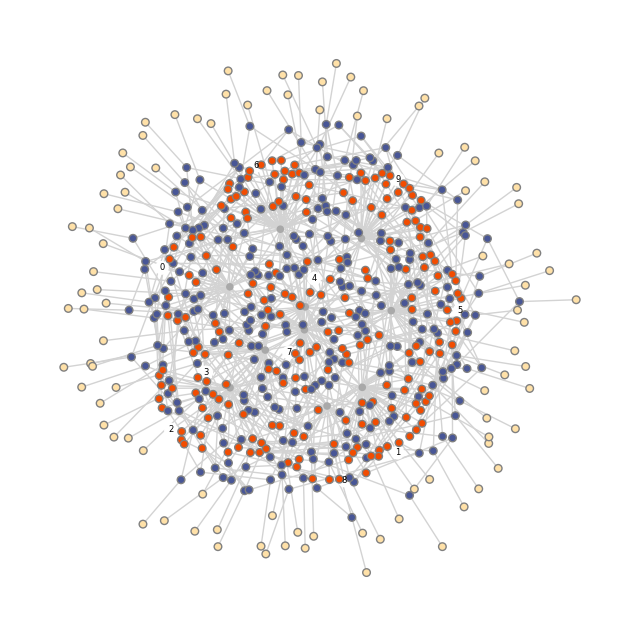

In [10]:
cnf = CNFInstance.random(k=4, n=10, m=95, rng=0)
cnf_diagram = cnf.diagram()
draw_diagram(
    cnf_diagram,
    node_color={"box": binop_colors},
    node_size={"box": 30},
    figsize=(8, 8),
)

In [11]:
cnf_diagram

<Diagram 0x2ed4a9b4fa0: 497 wires, 582 blocks, 10 ports>

Num contractions: 582
Total compute: 153.2 KiOPs
Total memory write: 70.4 KiB
Max tensor size: 4.0 KiB
Peak memory size: 15.2 KiB


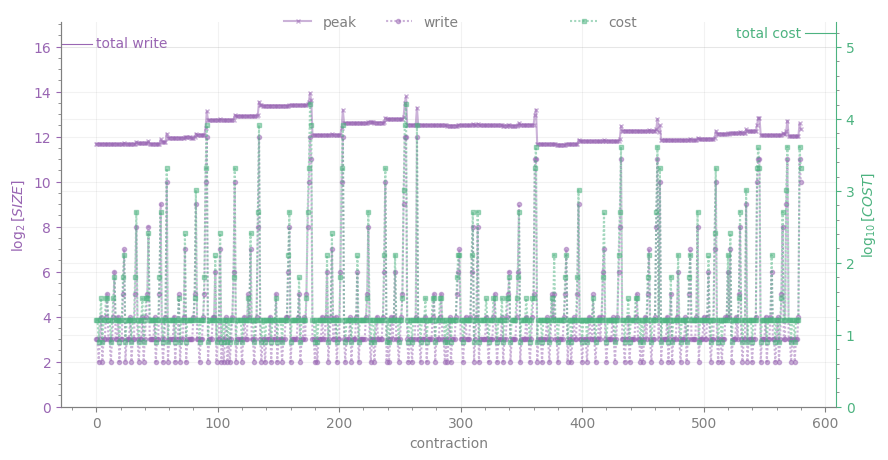

In [12]:
cnf_contraction = CotengraContraction(FinRel, cnf_diagram.wiring)
t = cnf_contraction.tree
describe_contraction(t)
t.plot_contractions(figsize=(10, 5));

Contracting the diagram yields a relation capturing all satisfying assignments to the formula:

In [13]:
cnf_solns = cnf_contraction.contract(cnf_diagram)
cnf_solns

<FinRel 0x2ed4d143770: 10 ports>

In [14]:
cnf_solns.to_set()

frozenset({(1, 0, 0, 1, 0, 0, 0, 0, 0, 0),
           (1, 0, 0, 1, 1, 0, 0, 0, 0, 0),
           (1, 0, 0, 1, 1, 1, 0, 1, 0, 0),
           (1, 0, 0, 1, 1, 1, 1, 1, 0, 0)})

## Medium 4-SAT Example

We consider a 4-SAT formula with 20 variables and 195 clauses.

In [15]:
cnf = CNFInstance.random(k=4, n=20, m=int(9.75*20), rng=1)
cnf_diagram = cnf.diagram()
cnf_diagram

<Diagram 0x2ed4c92dcc0: 992 wires, 1167 blocks, 20 ports>

For this example, we will not compute the full set of satisfying assignments.
Instead, we will check whether the formula is satisfiable, and then proceed to derive a single satisfying assignment.

The diagrams used to answer these questions are obtained by composing the CFN's diagram with assignments of values (0, 1 or unknown) to the CNF variables, generated using the CNF's `inputs` method.
The diagrams have no ports, and can therefore be contracted more efficiently than the CNF's diagram.

For the SAT/UNSAT question, all variables are set to unknown values.

In [16]:
cnf_sat_diagram = (cnf.inputs(None)>>cnf_diagram).flatten()
#                  ^^^^^^^^^^^^^^^^ all inputs set to bit_unk
cnf_sat_diagram

<Diagram 0x2ed4c92f150: 992 wires, 1187 blocks>

Num contractions: 1187
Total compute: 831.1 MiOPs
Total memory write: 119.7 MiB
Max tensor size: 32.0 MiB
Peak memory size: 72.0 MiB


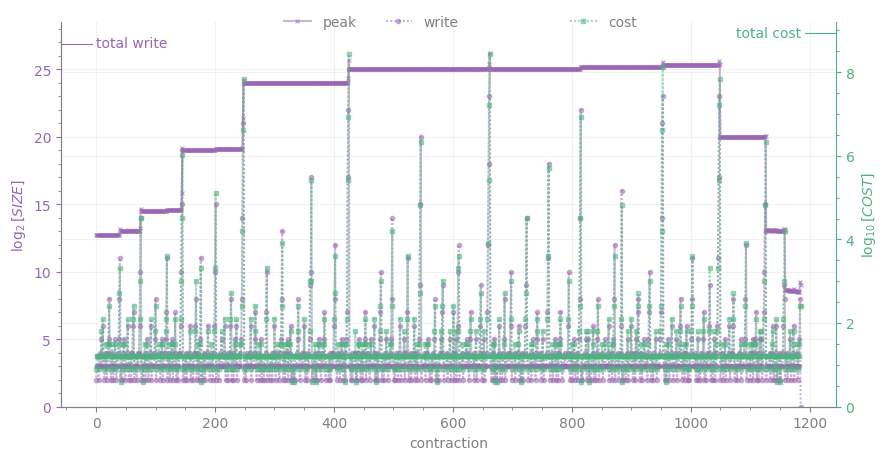

In [17]:
cnf_sat_contraction = CotengraContraction(FinRel, cnf_sat_diagram.wiring)
t = cnf_sat_contraction.tree
describe_contraction(t)
t.plot_contractions(figsize=(10, 5));

We now slice and reconfigure the contraction tree (inplace), targeting a maximum intermediate tensor size of 32KiB (as an example).
For more information on dynamic slicing and subtree reconfiguration, see:

- https://cotengra.readthedocs.io/en/latest/advanced.html
- https://cotengra.readthedocs.io/en/latest/trees.html#dynamic-slicing
- https://cotengra.readthedocs.io/en/latest/autoapi/cotengra/index.html#cotengra.ContractionTree.slice_and_reconfigure

The resulting diagram has 4 slices.


log10[FLOPs]=6.46 log2[SIZE]=15.00: : 3it [00:07,  2.47s/it]


Num contractions: 1187
Total compute: 2.7 MiOPs
Total memory write: 1.6 MiB
Max tensor size: 32.0 KiB
Peak memory size: 98.4 KiB
Num slices: 3


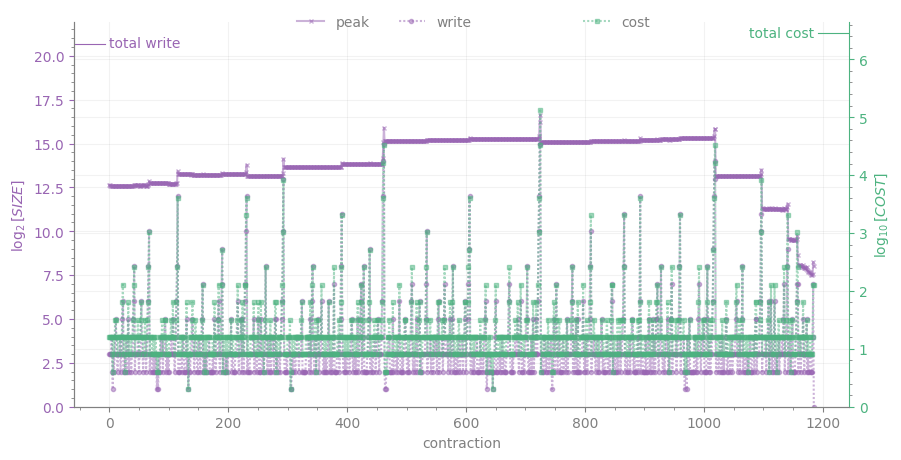

In [18]:
t.slice_and_reconfigure(
    target_size=2**15, # 32KiB
    progbar=True,
    inplace=True
)
describe_contraction(t)
t.plot_contractions(figsize=(10, 5));

If we contract the diagram, we obtain a scalar, i.e. a box with empty shape. Scalars can be converted to Boolean using the builtin `bool` constructor.

In [19]:
is_cnf_satisfiable = bool(cnf_sat_contraction.contract(cnf_sat_diagram))
is_cnf_satisfiable

True

We can compute a single satisfying assignment in $O(2n)$ contractions, where $n$ is the number of variables. The wiring is independent of the assignments of values to its variables, so the `cnf_sat_contraction` used above for the SAT/UNSAT question can be used to test partial assignments.

In [21]:
from typing import Literal
n = cnf.num_vars
assert n >= 1 # we want to use the empty string as a flag for unsat
assignment: str = ""
for i in range(n):
    found: Literal["0", "1"] | None = None
    for b in "01":
        candidate = assignment[:i]+b+"?"*(n-i-1)
        print(f"Testing candidate {candidate}...", end="")
        test_diag = (cnf.inputs(candidate)>>cnf_diagram).flatten()
        if cnf_sat_contraction.contract(test_diag):
            found = b
            print("sat")
            break
        else:
            print("unsat")
    if found:
        assignment += found
    else:
        assignment = ""
        break

Testing candidate 0???????????????????...unsat
Testing candidate 1???????????????????...sat
Testing candidate 10??????????????????...sat
Testing candidate 100?????????????????...sat
Testing candidate 1000????????????????...unsat
Testing candidate 1001????????????????...sat
Testing candidate 10010???????????????...unsat
Testing candidate 10011???????????????...sat
Testing candidate 100110??????????????...sat
Testing candidate 1001100?????????????...sat
Testing candidate 10011000????????????...unsat
Testing candidate 10011001????????????...sat
Testing candidate 100110010???????????...sat
Testing candidate 1001100100??????????...sat
Testing candidate 10011001000?????????...sat
Testing candidate 100110010000????????...sat
Testing candidate 1001100100000???????...unsat
Testing candidate 1001100100001???????...sat
Testing candidate 10011001000010??????...unsat
Testing candidate 10011001000011??????...sat
Testing candidate 100110010000110?????...unsat
Testing candidate 100110010000111?????...